gridworld 游戏的网格面板是正方形的，其大小指的是单条边的尺寸。本例创建 4*4 网格。有 3 种初始化方法：
1、静态初始化，如下所示，这样网格面板上的对象会初始化在相同的预定位置
2、设置 mode='player', 这样只有玩家可以初始化在网格上的随机位置
3、用mode='random'初始化，这样所有对象会随机放置

In [106]:
from Gridworld import Gridworld
game=Gridworld(size=4,mode="static")

调用 display 显示网格面板

In [107]:
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

调用 makemove 方法进行移。每个未获胜的移动都将获得-1 的奖励，获胜的移动将获得 +10 的奖励，失败（落入坑中）将获得 -10 的奖励。

In [108]:
game.makeMove('d')

In [109]:
game.makeMove('d')

In [110]:
game.makeMove('l')

In [111]:
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

每次移动后，调用 reward 查看动作奖励或输出

In [112]:
game.reward()

-1

将游戏状态输入神经网络中，下段代码运行的是游戏实际状态的表示

In [113]:
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

状态被表示为 4*4*4 的张量。每个矩阵编码了 4 个对象中其中一个的位置：玩家、目标、坑和墙。如果将调用的 display 方法的结果与游戏状态对比，发现第一个矩阵编码了玩家的位置，第二个矩阵编码了目标的位置，第三个矩阵编码了坑的位置，第四个矩阵编码了墙的位置。

In [114]:
game.board.render_np().shape

(4, 4, 4)

In [115]:
import numpy as np
import torch
from  Gridworld import *
import random
from matplotlib import pyplot as plt

model=torch.nn.Sequential(
    torch.nn.Linear(64,150),
    torch.nn.ReLU(),
    torch.nn.Linear(150,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,4)
)
loss_fn=torch.nn.MSELoss()
learning_rate=1e-3
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

gamma=0.9
epsilon=1.0

实现该算法的主循环，包括以下操作：

1、设置一个执行指定数量轮次的 for 循环

2、在循环中，设置一个 while 循环（在游戏进行过程中）

3、正向运行Q网络

4、用一个$\epsilon$贪婪算法实现，所以在 t 时刻会以概率 $\epsilon$ 选择随机动作，另外以概率 1-$\epsilon$ 从神经网络中选择最大Q值对应的动作

5、采取动作 4中所确定的动作 a，并观测新的状态$s^{'}$和奖励$r_{t+1}$

6、使用$s^{'}$向前运行网络，并存储最大的Q值

7、训练网络的目标值为$r_{t+1}+\gamma maxQ_{A}(s_{t+1})$其中$\gamma$是一个值为 0 到 1 的参数。如果采取动作$a_{t}$后游戏结束，就没有合法分$s_{t+1}$，所以此时$\gamma maxQ_{A}(s_{t+1})$无效，为此我们可以将他设置为 0，目标就变成了$r_{t+1}$

8、考虑到有四个输出，但我们只希望更新（训练）与刚刚执行动作相关的输出，也就是说，除了将与该动作关联的输出改变成使用Q-learning公式计算得到的结果，目标输出向量与第一次运行的输出向量相同

9、在该样本上训练模型，然后重复步骤 2到 9

由于Q-learning算法只知道如何生成数，所以需要一个数值键到动作字符的简单映射

In [116]:
action_set={
    0:'u',
    1:'d',
    2:'l',
    3:'r',
}   

主训练循环

在游戏状态中加噪声，有助于防止“死亡神经元”。使用ReLU作为激活函数时就会出现这种情况。实质上，由于游戏状态数组中的大部分元素为 0，而ReLU理论上在 0 处不可微分，因此并不能与ReLU较好的配合。所以添加一点点的噪声，这样的状态数组中就没有完全为 0 的值。这也有助于解决过拟合问题。

In [117]:
epochs=1000
#创建一个列表来存储损失值，以便稍后绘制趋势图
losses=[]
for i in range(epochs):
    game=Gridworld(size=4, mode='static') #在每个轮次中，开始一个新游戏
    #创建游戏后，提取状态信息并添加少量噪声
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    #将numpy数组转换为pytorch张量，在转换为 pytorch 变量
    state = torch.from_numpy(state_).float() 
    status = 1 #用状态变量来跟踪游戏是否仍在进行中
    while(status == 1): #若游戏仍在进行，就一直玩到结束，然后开始一个新的轮次
        qval = model(state) #继续运行Q网络，以获得所有动作的预测Q值
        #将张量转换为numpy数组，以便我们可以从中选择一个动作
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):   #用epsilon-greedy策略选择动作
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        #将数字动作转换为Gridworld游戏所期望的其中一个动作字符
        action = action_set[action_] 
        game.makeMove(action)   #用epsilon-greedy策略选择动作，并将其应用到游戏上
        #render_np方法将游戏状态渲染为一个NumPy数组。
        #由于render_np方法返回的是一个形状为(4, 4, 4)的张量，这行代码通过.reshape(1,64)将其重塑为一个形状为(1, 64)的张量。
        #这是为了匹配神经网络的输入要求，其中每个游戏状态被视为一个64维的向量。
        #后面部分代码向游戏状态向量中添加了一些噪声。
        #np.random.rand(1,64)生成一个形状为(1, 64)的随机数组，其元素在[0, 1)范围内均匀分布。
        #然后，这个数组被除以10.0以减小噪声的幅度，并加到原始游戏状态向量上。
        #添加噪声可能是为了增强神经网络的泛化能力，使其能够处理稍微不同的游戏状态。
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float() #采取动作后获得游戏的新状态，并将其转换为张量
        reward = game.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1,64))
        maxQ = torch.max(newQ) #查找从新状态预测的最大Q值
        if reward == -1: #计算目标 Q 值。
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        #将[Y]传递给torch.Tensor构造函数，会创建一个新的Tensor，这个Tensor只包含一个元素，即Y
        #通过.detach()方法从这个新Tensor创建一个与其数据共享但不记录计算历史的新Tensor，并将这个新Tensor赋值给变量Y。
        #这样做可能是为了避免后续对这个Tensor的操作影响到梯度计算，或者是为了确保这个Tensor不会被自动求导系统追踪
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] #创建qval数组的一个副本，然后更新与所采用动作对应的元素
        loss = loss_fn(X, Y) 
        optimizer.zero_grad()
        loss.backward()
        #append() 是Python列表的一个方法，用于在列表的末尾添加一个元素。
        #item() 是PyTorch Tensor的一个方法，用于将只包含单个元素的Tensor转换为Python标量。
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1: #如果奖励为-1，则表示游戏尚未胜利或失败，仍在进行中
            status = 0
    if epsilon > 0.1: #每一个轮次中都减小 Epsilon 的值
        epsilon -= (1/epochs)

Text(0, 0.5, 'Loss')

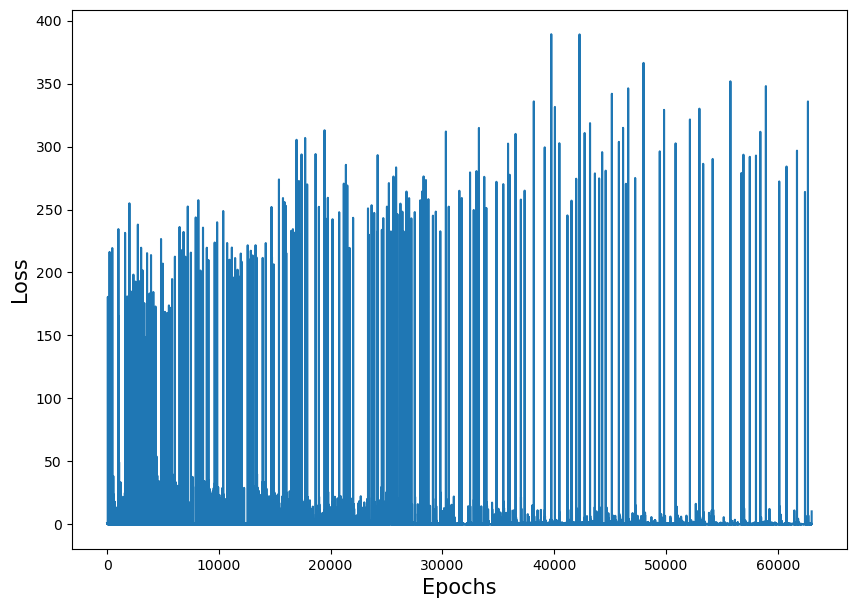

In [136]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)

创建两个可训练的参数m和b，通过将他们的require_grad设置为True来实现。这意味着 pytorch 将这些参数作为计算图中的节点，并存储他们的计算历史。对于任何使用m和b创建的新张量（例如y），也将其require_grad设置为True，即也将记录他们的计算历史。

In [119]:
m = torch.Tensor([2.0])
#requires_grad：布尔属性，用于指示是否需要对这个张量进行梯度计算
m.requires_grad=True
b = torch.Tensor([1.0])
b.requires_grad=True
def linear_model(x,m,b):
    y = m@x+b
    return y
#with torch.no_grad():
y = linear_model(torch.Tensor([4]),m,b)

In [120]:
y.grad_fn

In [121]:
y

tensor([9.], grad_fn=<AddBackward0>)

In [132]:
#with torch.no_grad():
y = linear_model(torch.Tensor([4]),m,b)

In [126]:
y

tensor([9.])

In [127]:
y.grad_fn

In [133]:
y.backward()

In [134]:
m.grad

tensor([4.])

In [135]:
b.grad

tensor([1.])

Q网络测试结果

In [138]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #游戏进行期间
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #采取Q值最大的动作   
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

测试函数本质上与训练循环中的代码相同，他不做任何损失计算或反向传播，只是正向运行网络来获得预测值

In [141]:
test_model(model, 'random')

Initial State:
[['-' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' 'P' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 0; Taking action: r
[['-' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' 'P' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 1; Taking action: u
[['-' ' ' ' ' '+']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 2; Taking action: r
[['-' ' ' ' ' '+']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 3; Taking action: u
[['-' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Game won! Reward: 10


True

In [149]:
test_model(model,'static')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: u
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: u
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: u
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: u
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: u
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 7; Taking action: u
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 8; Taking action: u
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [

False

In [152]:
l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

对静态来说，不需要担心遗忘性问题，因为目标总是固定的。在随机模式中，就需要考虑这一点，这也是需要实现的经验回放的原因。经验回放基本上可以让我们在在线学习方案中进行批量更新，实现起来也没什么问题。

经验回放的工作原理：

1、在状态s下采取动作a，观测奖励$r_{t+1}$和状态$s_{t+1}$

2、将其作为一个元组$(s,a,r_{t+1},s_{t+1})$存储在一个列表中

3、继续将每个经验存储在该列表中，直到将列表填充到特定长度为止（取决于你的定义）

4、如果经验回放内存已满，就随机选择一个子集（同样，需要定义子集的大小）

5、遍历子集并计算每个子集的值更新，将其存储在一个目标数组（例如Y）中，并存储X中每条经验的状态s

6、使用X和Y作为小批量进行批量训练。对于数组已满的后续轮次，只需要覆盖经验回放内存数组中的旧值

经验回放的工作原理。经验回放是一种缓解在线训练算法主要问题（灾难性遗忘）的方法。其理念是存储过去的经验，然后使用这些经验的随机子集来小批量更新Q网络，而非只使用最近的一条经验

为了存储智能体的经验，使用了 Python 内置库 collections 中的双端队列 deque数据结构。他本质上是一个可以设置最大尺寸的列表，这样如果尝试向已满的列表追加项目，那么他将删除列表中的第一个项目，并将新项目添加到列表的末尾，这意味着新的经验会取代最旧经验，经验本身是（状态1，动作，奖励，状态2，done）形式的元组，我们会将元组附加到双端队列 replay 中。

经验回放训练的主要区别在于，如果回放列表已满，则会以小批量数据进行训练。从回放列表中随机选择一个经验子集，并将单独的经验组件分离为state1_batch、action_batch、reward_batch、state2_batch和done_batch。使用张量的 gather 方法通过动作索引获取Q1 张量的子集，这样只选择与实际被选择的动作相对应的Q值。

In [153]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #设置经验回放内存总大小
batch_size = 200 #设置小批量大小
replay = deque(maxlen=mem_size) #将经验回放创建为一个deque列表
max_moves = 50 #设置游戏结束前的最大移动次数
h = 0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1) #输入状态计算Q值来选择一个动作
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #用贪婪策略选择一个动作
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done) #以元组的形式创建一条状态、动作、奖励、下一个状态的经验
        replay.append(exp) #将经验添加到经验回放列表中
        state1 = state2
        
        if len(replay) > batch_size: #如果回放列表长度大于小批量大小，则开始小批量训练
            minibatch = random.sample(replay, batch_size) #随机抽样回放列表的子集
            
            #将每个经验的组成部分分离成单独的小批量张量
            #torch.cat()：是PyTorch中的拼接函数，用于将一系列张量（Tensor）沿指定的维度拼接起来。
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) 
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #重新计算小批量状态的Q值，以得到梯度
            
            with torch.no_grad():
                Q2 = model(state2_batch) #计算下一批状态的Q值，但不计算梯度
            #计算想让DQN学习的目标Q值
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) 
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves: #如果游戏结束，则重置状态和移动次数
            status = 0
            mov = 0
losses = np.array(losses)


In [166]:
#计算数组 x 的滑动平均值。N：滑动窗口的大小，默认值为 50
def running_mean(x,N=50):
    #x.shape[0] 用于获取数组 x 的长度（元素个数）
    #c 表示可以计算滑动平均值的元素数量，因为要计算长度为 N 的滑动窗口的平均值，
    #所以最后 N - 1 个元素无法计算完整的滑动平均值，因此 c 等于数组 x 的长度减去 N
    c = x.shape[0] - N
    #初始化存储滑动平均值的数组
    y = np.zeros(c)
    #使用np.ones函数创建一个长度为N的全1数组conv，这个数组将作为滑动窗口的卷积核，用于计算窗口内元素的和。
    conv = np.ones(N)
    for i in range(c):
        #x[i:i+N] 表示从数组 x 中截取长度为 N 的子数组，即当前的滑动窗口
        #x[i:i+N] @ conv 表示将截取的子数组与卷积核 conv 进行点积运算，
        #由于 conv 是全 1 数组，所以点积运算的结果就是窗口内元素的和。
        y[i] = (x[i:i+N] @ conv)/N
    return y

Text(0, 0.5, 'Loss')

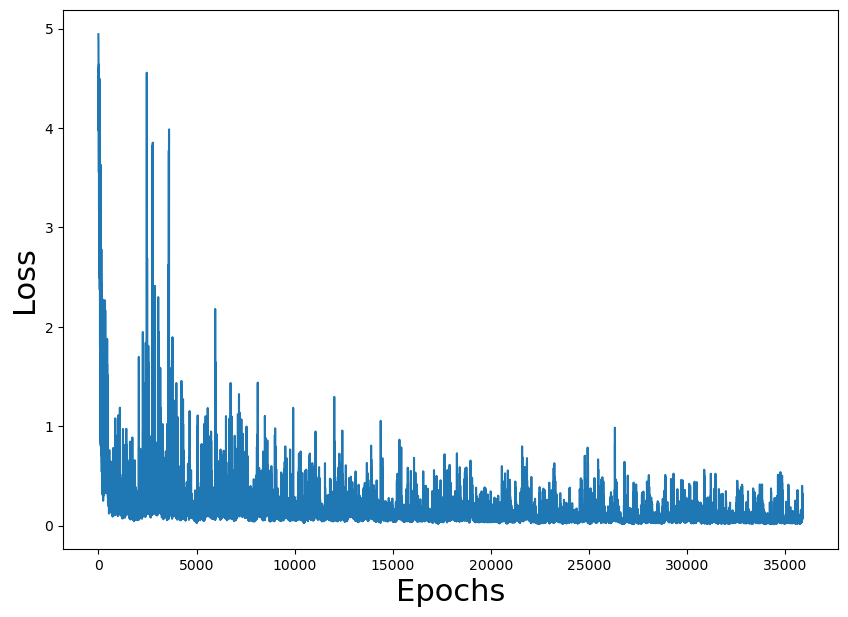

In [169]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

测试经验回放的性能

In [171]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 918
Win percentage: 91.8%


In [172]:
test_model(model, mode='random')

Initial State:
[['+' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' 'W' '-' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[['+' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' 'W' '-' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

在开始训练之前，目标网络与Q网络完全相同，但是就如何更新而言，他自己的参数滞后于常规的Q网络。

我们在目标网络中再次运行事件序列（此处省略经验回放的细节）

1、以参数（权重）$\theta_{Q}$初始化Q网络    

2、初始化目标网络为Q网络的副本，但是具有单独的参数$\theta_{T}$，并设置$\theta_{T}=\theta_{Q}$ 

3、使用带有Q网络Q值的e贪婪策略选择动作a

4、观察奖励$r_{t+1}$和新状态$s_{t+1}$

5、如果轮次终止（赢或输掉游戏），那么目标网络的Q值将被设置为$r_{t+1}$，否则它将是$r_{t+1}+\gamma maxQ_{\theta_{r}}(s_{t+1})$（注意此处目标网络的使用）

6、通过Q网络（不是目标网络）反向传播目标网络的Q值

7、没迭代C次，设置$\theta_{T}=\theta_{Q}$（例如，设置目标网络的参数等于Q网络的参数）

![alt text](image.png)
图中唯一一次使用目标网络Q是为了通过Q网络的反向传播计算目标Q值。其思想是在每次训练迭代时更新主要的Q网络参数，但是我们减小了最近的更新对动作选择的影响，以期提高稳定性。

目标网络的Q网络，他的预测Q值用于反向传播和训练主Q网络。目标网络的参数不会被训练，但他们会定期同步Q网络的参数，其思想是利用目标网络的Q值训练Q网络将提高训练的稳定性。

目标网络

目标网络只是主DQN的一个滞后副本。每个 pytorch 模型中都有一个state_dict方法，他以字典形式返回模型中的所有参数。使用 Python 内置的copy模块来复制 pytorch 模型数据结构，然后对 model2 使用其load_state_dict方法，以确保他复制了主DQN的参数。

In [173]:
import copy

l1 = 64
l2 = 150
l3 = 100
l4 = 4


model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)

#deepcopy函数用于创建一个对象的深层副本。这意味着它不仅复制对象本身，还递归地复制对象中包含的所有子对象。
#这样，原始对象和新对象之间就没有共享的子对象，它们是完全独立的。
model2 = copy.deepcopy(model) #通过复制原始Q网络模型来创建另一个模型
#model.state_dict()：这个方法返回模型的状态字典，它是一个从参数名称映射到参数张量的字典对象。
#   这个状态字典包含了模型的所有可训练参数和不可训练参数（如权重和偏置）
#model2.load_state_dict(...)：这个方法接收一个状态字典作为输入，并将该状态字典中的参数加载到model2中。
#   如果model2和状态字典中的参数结构相匹配，那么这些参数将被更新为状态字典中的值。
model2.load_state_dict(model.state_dict()) #复制原始模型参数

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

有经验回放和目标网络的DQN

In [175]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0
sync_freq = 500 #设置更新频率，以便将目标模型参数同步到主DQN
#变量 j 主要用来记录总的步数，并且控制目标模型参数同步到主DQN的频率
j=0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        j+=1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp) 
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch) #使用目标网络获得下一个状态的最大Q值
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            #控制目标模型参数同步频率
            if j % sync_freq == 0: #将主模型参数复制到目标网络
                #每走 500 步，就会把主 DQN 模型 model 的参数同步到目标模型 model2 中
                model2.load_state_dict(model.state_dict())
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
        
losses = np.array(losses)

通过加入一个目标网络来稳定训练后的DQN损失图。与不包含目标网络相比，其训练收敛速度快的多，但当目标网络与主DQN同步时，有明显的误差峰值

Text(0, 0.5, 'Loss')

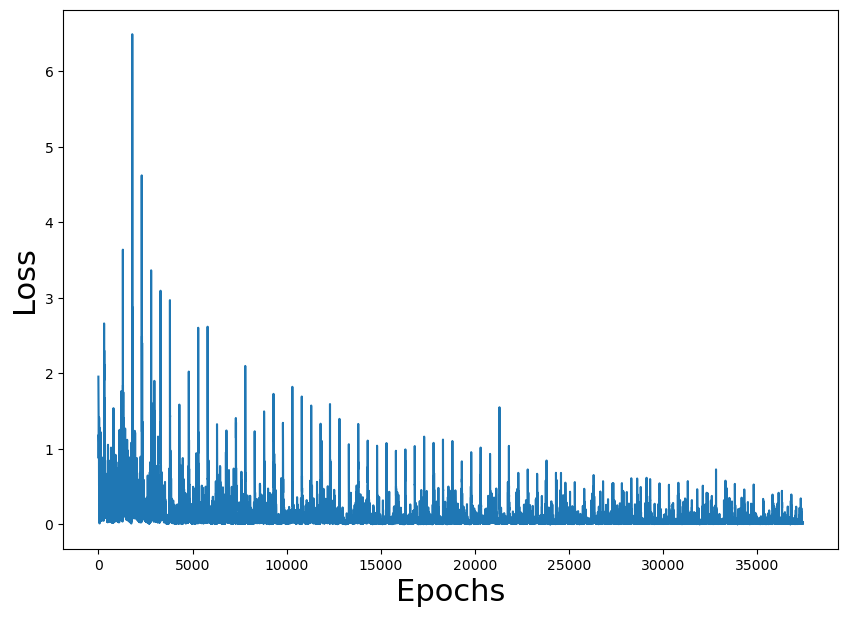

In [176]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [177]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 921
Win percentage: 92.10000000000001%


离线策略学习：指学习一个策略时使用不同的策略来收集数据

在线策略学习：指在学习一个策略的同时使用相同的策略来收集学习的数据

经验回放：是一种允许对强化学习算法进行批量训练的机制，以减少灾难性遗忘并提高学习效率提高训练稳定性

目标网络是主DQN的副本，可用于稳定训练主DQN的更新规则